# 循环神经网络

## 《时间机器》数据集相关实验

In [99]:
import tarfile
import zipfile
import hashlib
import os
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name, cache_dir=os.path.join('..', 'data')):
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    # exist_ok表示如果这个目录存在也ok，False的话就会报错
    os.makedirs(cache_dir, exist_ok=True)
    # os.path.join 用于把目录和文件名合成一个路径
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

### 读取数据集

In [100]:
import re

DATA_HUB['time_machine'] = (DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():
    """将时间机器数据集加载到文本行的列表中"""
    # d2l.download
    with open(download('time_machine'), 'r') as f:
        lines = f.readlines()
    # regular expression substitute（替换）
    # 这里[^A-Za-z]+的含义是匹配除了字母A-Z和a-z外的字符，一次到多次，替换为空格
    # 然后strip移除字符串头尾的空格，化为小写后完毕。
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

### 词元化

In [101]:
def tokenize(lines, token='word'):
    """将文本行拆分为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)

### 建立词表

In [102]:
import collections


class Vocab:
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 获取词元展平后的Counter对象。
        counter = count_corpus(tokens)
        # 私有变量，词元频率（事实上是伪私有）
        # 按出现频率排序，sorted() 函数用于对所有可迭代的对象进行排序操作。
        # counter.items()等同于字典的items()函数，返回一个可迭代的集合数据结构
        # 参数key是用来进行比较的元素，指定可迭代对象中的一个元素来进行排序，这里指的是每一个tuple中的第二个元素，即频率
        # reverse参数：True为降序，False为升序，默认False
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 生成词元列表
        # 左加使未知词元的索引为0, 如：['<unk>', ...]
        self.idx_to_token = ['<unk>'] + reserved_tokens
        # 生成词元与索引对应的字典
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            # 发现新词，在词元列表中加入该词，然后在词元-索引字典中添加该词及其索引
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    # 定义该方法使得Vocab类可以以 p[key] 的方式取值
    # 此处‘key’的格式可以为单个词、list或tuple
    def __getitem__(self, tokens):
        # 单个词
        if not isinstance(tokens, (list, tuple)):
            # 如果查找不到则返回频率0（unk）
            return self.token_to_idx.get(tokens, self.unk)
        # 可遍历对象，返回一个频率列表
        return [self.__getitem__(token) for token in tokens]

    # 接受索引返回词元
    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    # property装饰器，可以直接通过方法名来访问方法，不需要在方法名后添加圆括号“()”
    # 如：vacab.unk、vacab.token_freqs
    # 相当于getter方法，访问私有成员的接口
    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    # 返回一个Counter对象，该对象是一个高性能的容器数据类型，有许多作用
    # 对于取频率这件事，直接dict（counter）就可以得到频率字典。
    return collections.Counter(tokens)

In [103]:
def load_corpus_time_machine(max_tokens=-1):
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()

### 随机采样

In [104]:
import random

def seq_data_iter_random(corpus, batch_size, num_steps):
    """从数据中随机生成一个小批量"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    # 词数除去时间步长得到子序列的总数量
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的各个子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    # 也就是打乱起始索引列表
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    # 对子序列分批，子列数量除去批量大小得到批次数量
    num_batches = num_subseqs // batch_size
    # 这里的range方式与之前相同，就是获取批次的起始索引
    for i in range(0, batch_size * num_batches, batch_size):
        # initial_indices包含子序列的随机起始索引
        # 获取当前批次对应的子序列起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        # 训练数据
        X = [data(j) for j in initial_indices_per_batch]
        # 训练数据后移一个词元得到标签
        Y = [data(j + 1) for j in initial_indices_per_batch]
        # 生成器
        yield torch.tensor(X), torch.tensor(Y)

### 顺序采样

In [105]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    # 可用词元的数量
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    # 所有特征
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    # 所有标签
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    # 分批，第二维中对应各批次的数据（其实是索引）
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    # 这里其实写的有些奇怪，批次数量num_batches和批次大小事实上都是
    # 相对于子列数量而言的，而上一步直接在原始数据和批次大小间建立联系
    # 不过无所谓，最终只是要获取批次数量的值而已，该值的公式：
    # 批次数量 = 子列数量//批次大小
    # 子列数量 = 原始数据//时间步长
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

### 组装

In [106]:
class SeqDataLoader:
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    # 定义 __iter__ 表示这个类是一个迭代器，只在迭代开始的时候运行一次
    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)


def load_data_time_machine(batch_size, num_steps,
                           use_random_iter=False, max_tokens=10000):
    """
    返回时光机器数据集的迭代器和词表
    :param max_tokens 默认最大词元数10000
    """
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

### 跑模型预备

In [107]:
import time
import numpy as np
from matplotlib_inline import backend_inline
import matplotlib.pyplot as plt
from IPython import display

def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    # with 语句适用于对资源进行访问的场合，确保不管使用过程中是否发生异常都会执行必要的“清理”操作，释放资源，比如文件使用后自动关闭／线程中锁的自动获取和释放等。
    # with torch.no_grad()：在该模块下，所有计算得出的tensor的requires_grad都自动设置为False，无论是否指定requires_grad。
    with torch.no_grad():
        for param in params:
            # 由于param会接收列表形式的参数，列表属于可变对象，会采用引用传递的方式，也就是此处的改变会作用到实参上。
            param -= lr * param.grad / batch_size
            # 清除梯度值，只能在梯度值被计算过至少一次后使用。
            param.grad.zero_()

class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    # 这里的 == 也是一个张量运算符，是判断预测与标签是否相同并得到结果张量，如tensor([False,  True])。
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy_gpu(net, data_iter, device=None):
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


def use_svg_display():
    """使用svg格式在Jupyter中显示绘图"""
    backend_inline.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    """设置matplotlib的图表大小"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """绘制数据点"""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # 如果X有一个轴，输出True
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)


class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


class Timer:
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

## 循环神经网络的从零实现

### 读取数据

In [108]:
import math
import torch
from torch import nn
from torch.nn import functional as F

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

### 初始化模型参数

In [109]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### 初始化时返回隐状态

In [110]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

### 定义了如何在一个时间步内计算隐状态和输出

In [111]:
def rnn(inputs, state, params):
    # inputs的形状：(时间步数量，批量大小，词表大小)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # X的形状：(批量大小，词表大小)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

### 包装这些函数， 并存储从零开始实现的循环神经网络模型的参数

In [112]:
class RNNModelScratch:
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)


用X检查输出是否具有正确的形状，如隐状态的维数是否保持不变。

In [113]:
X = torch.arange(10).reshape((2, 5))
# 独热编码检验，时间步数、批量大小、词表大小。
print(F.one_hot(X.T, 28).shape)

num_hiddens = 512
net1 = RNNModelScratch(len(vocab), num_hiddens, torch.device('cpu'), get_params,
                      init_rnn_state, rnn)
# 这里batch size是X的第一维，值为2
state1 = net1.begin_state(X.shape[0], torch.device('cpu'))
Y, new_state = net1(X.to(torch.device('cpu')), state1)
Y.shape, len(new_state), new_state[0].shape

torch.Size([5, 2, 28])


(torch.Size([10, 28]), 1, torch.Size([2, 512]))

可以看到输出形状是（时间步数$\times$批量大小，词表大小），而隐状态形状保持不变，即（批量大小，隐藏单元数）。

### 预测

In [114]:
def predict_ch8(prefix, num_preds, net, vocab, device):
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # 预热期
        # 只使网络更新隐状态，但向outputs中添加prefix中的字符。
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

测试预测
将前缀指定为time traveller， 并基于这个前缀生成10个后续字符。
此时还没有训练网络，它会生成荒谬的预测结果。

In [115]:
predict_ch8('time traveller ', 10, net1, vocab, torch.device('cpu'))

'time traveller vazbxzaqtu'

### 梯度剪裁

In [116]:
def grad_clipping(net, theta):
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    # 范数，平方和
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

### 训练

In [117]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, Timer()
    metric = Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            # 已有隐状态，在处理小批量前先分离梯度。
            # tensor.detach_()将一个tensor从创建它的图中分离，并把它设置成叶子tensor。是对tensor本身的更改。
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        # 加载到显存
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        # grad_clipping-梯度裁剪
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            # 开始优化一次
            updater.step()
        # 如果优化函数是非框架的实现
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    # 定义损失函数，交叉熵
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化，设定参数优化器（小批量随机梯度下降），指定参数表和学习率。
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: sgd(net.params, lr, batch_size)
    # 设定预测函数
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

### 开始训练

顺序采样

困惑度 3.1, 74793.9 词元/秒 cpu
time travellerthow and hregut you anond and ss he walle rother d
traveller but contin and the time travellert ghene dimensio


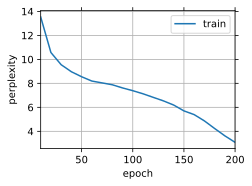

In [118]:
# 因为在数据集中只使用了10000个词元， 所以模型需要更多的迭代周期来更好地收敛。
# 这里减少周期是由于机器性能限制，当迭代500周期时，模型会较为收敛。
num_epochs, lr = 200, 1
train_ch8(net1, train_iter, vocab, lr, num_epochs, torch.device('cpu'))

随机抽样

困惑度 4.2, 79992.0 词元/秒 cpu
time traveller thichthe ong mided ffired for mathematicileply ca
traveller for this thating thively for this that hest and h


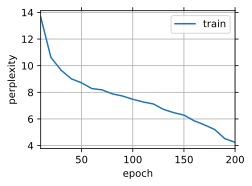

In [119]:
net1 = RNNModelScratch(len(vocab), num_hiddens, torch.device('cpu'), get_params,
                      init_rnn_state, rnn)
train_ch8(net1, train_iter, vocab, lr, num_epochs, torch.device('cpu'),
          use_random_iter=True)

## 循环神经网络的框架实现

读数据

In [120]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

构建模型

In [121]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的，num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

基于随机权重预测

In [122]:
device = torch.device('cpu')
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
predict_ch8('time traveller', 10, net, vocab, device)

'time travelleraaaaaaaaaa'

困惑度 1.6, 185522.7 词元/秒 cpu
time traveller held way exor wa seales that ix allarily centai l
traveller be said the medical man there are balloongbutabce


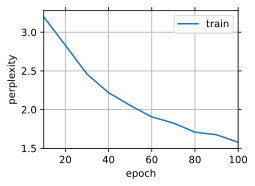

In [124]:
# 设备不行就减少周期吧😊
num_epochs, lr = 100, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, device)

这章都选择在CPU中训练是因为在GPU训练会出现无数据的情况，猜测是显存不足？